In [1]:
# File system interaction
import os

# Numerical analysis
import numpy
import pandas
from scipy.optimize import curve_fit

#Graphing
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
color_map = plt.get_cmap('viridis')
%matplotlib inline

#Image analysis
import skimage
from skimage import io
from skimage.filters import threshold_otsu
from skimage.filters.rank import median
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import binary_closing, closing, square, disk
from skimage.color import label2rgb

In [2]:
def split_line_to_dict(line, output_dict, delim='='):
    ''' Function to convert line of text into key value pair'''
    split_line = line.split(delim)
    if len(split_line)==2:
        key = split_line[0].strip()
        value = split_line[1].strip()
        output_dict[key] = value
    return output_dict

def read_dovi(file):
    ''' Function to read CDose metadata'''
    dovi_data = {}
    new_file = "{}.new".format(file)
    with open(file, "r") as f:
        file_content = f.readlines()
    # Remove extra white spaces an beginning or end of each line
    file_content = [x.strip() for x in file_content] 
    for each_line in file_content:
        dovi_data = split_line_to_dict(each_line, dovi_data)
    return dovi_data


In [3]:
# Experiment name
cur_experiment = 'CELSI  Phantom2'
# Experiment timestamp created by CDose camera
cur_dataset = '2018-08-09 13-22-18-459'
# Base directory for reading and writing data
input_dir = '/Users/ethanlarochelle/Notebook Data/Dartmouth/input/Cherenkov/2018_08_09/'
output_dir = '/Users/ethanlarochelle/Notebook Data/Dartmouth/output/Cherenkov/2018_08_09'

full_input_dir = os.path.join(input_dir, cur_experiment, cur_dataset)


In [4]:
# Read image data
# s1 is Cherenkov
# s0 is Background

dovi_full_file = os.path.join(full_input_dir, 'meas_s1_cam0.dovi')
meta_data = read_dovi(dovi_full_file)
settings_file = os.path.join(full_input_dir, 'settings.ini')
settings = read_dovi(settings_file)
current_full_file = os.path.join(full_input_dir, 'meas_s1_cam0.raw')
height = int(meta_data['dims0'])
width = int(meta_data['dims1'])
z = int(meta_data['dims2'])

with open(current_full_file,'rb') as file:
    byte_array = numpy.fromfile(current_full_file, dtype='uint16')
    print(width,height,z)
    reconstructed_im = numpy.reshape(byte_array, [z, width, height])

600 800 1880


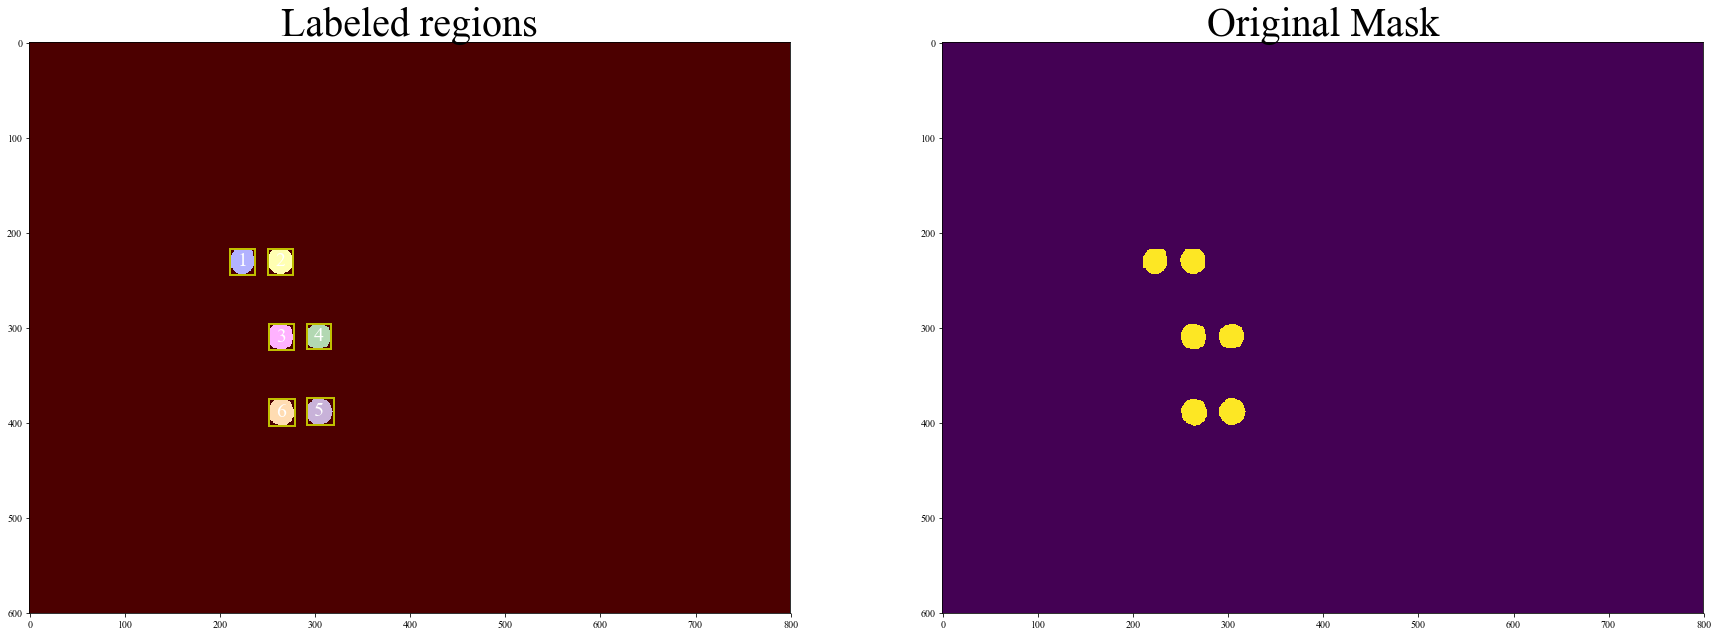

In [5]:
# Read previously made mask file and find ROIs
# A mask file is just a black and white image (no grayscale)
# It is used define specific regions of interest, like wells in a 96-well plate
mask_file = '96well_mask.png'
mask_im = numpy.fliplr(io.imread(os.path.join(input_dir, mask_file)))
mask_bw = mask_im.astype(numpy.bool)

# Minimum size of ROI
# This isn't entirely needed with a pre-made mask, but it helps in when noise is a problem
size_threshold =150

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(1,2,figsize=(30,24))
i = 0 

# label image regions
label_image = label(mask_bw)
image_label_overlay = label2rgb(label_image, image=mask_bw)

# Show labeled mask
example_ax = axarr[i].imshow(image_label_overlay)

# Identify each ROI in figure
for region in regionprops(label_image):
    # Only take regions with large enough areas
    if region.area >= size_threshold:
        # Draw rectangle around segmented ROIs
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='y', linewidth=2)
        axarr[i].add_patch(rect)
        
        # Display label on each region
        centroid_y = region.centroid[0]
        centroid_x = region.centroid[1]
        cur_label = str(region.label)
        axarr[i].text(centroid_x, centroid_y, cur_label, size=20, 
                ha='center', va='center', color='w')

axarr[i].set_title('Labeled regions', size=40)

axarr[i+1].imshow(mask_im)
axarr[i+1].set_title('Original Mask', size=40)

#plt.savefig(os.path.join(output_dir, 'Mask_used_for_{}.png'.format(cur_experiment)), bbox_inches='tight')
plt.show()

In [6]:
# Input which ROIs are actually of interest and revise the mask
# Somtimes we don't need every ROI, so this provides user ability to choose
roi_map = {
        1: 'Control',
        2: 'Control + G.O.',
        3: 'Compound1 + G.O.',
        4: 'Compound1',
        5: 'Compound2',
        6: 'Compound2 + G.O.'
    }
# Create new mask image array of all zeros
revised_mask = numpy.zeros(numpy.shape(mask_bw))
for region in regionprops(label_image): 
    #Only add ROIs in roi_map
    if region.label in roi_map.keys():
        minr, minc, maxr, maxc = region.bbox
        revised_mask[minr:maxr, minc:maxc]=1
revised_mask = numpy.logical_and(mask_bw,revised_mask)

In [7]:
# Loop though all image frames in stack and collect ROI statistics
# Store information in pandas DataFrame 
measurements_df = pandas.DataFrame()
j = 0
k = 0
for j in range(z):
    cur_im = reconstructed_im[j,:,:]
    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= size_threshold:
            minr, minc, maxr, maxc = region.bbox
            min_xy = numpy.round([minc, minr],0).astype('int')
            max_xy = numpy.round([maxc, maxr],0).astype('int')
            # Find indicies of mask that are not zero
            idx = revised_mask[min_xy[1]:max_xy[1], min_xy[0]:max_xy[0]]!=0
            roi_im = cur_im[min_xy[1]:max_xy[1], min_xy[0]:max_xy[0]].astype(numpy.float64)
            if numpy.size(roi_im[idx])>0:
                # Only use the pixel loactions defined by idx to calculate statistics
                roi_count = numpy.size(roi_im[idx])
                roi_mean = numpy.nanmean(roi_im[idx])
                roi_std = numpy.nanstd(roi_im[idx])
                roi_median = numpy.nanmedian(roi_im[idx]);
                roi_90p = numpy.nanpercentile(roi_im[idx],90)
                roi_max = numpy.nanmax(roi_im[idx])
                roi_min = numpy.nanmin(roi_im[idx])
                #Store measurements for current ROI
                roi_stats = {
                    'experiment': cur_experiment,
                    'series': cur_dataset,
                    'exposure': int(settings['ExposureTime']),
                    'frame': int(j),
                    'roi': str(region.label),
                    'label': roi_map[region.label],
                    'count': roi_count,
                    'mean': roi_mean,
                    'std': roi_std,
                    'median': roi_median,
                    '90p': roi_90p,
                    'max': roi_max,
                    'min': roi_min
                }
                # Create dataframe for current data and add index
                tmp_df = pandas.DataFrame(data=roi_stats, index=[k])
                k+=1
                # Append current data to dataframe
                measurements_df = measurements_df.append(tmp_df)
sorted_measurements_df = measurements_df.sort_values(by=['label', 'frame',]).drop_duplicates()  

In [8]:
sorted_measurements_df.head(1)

,experiment,series,exposure,frame,roi,label,count,mean,std,median,90p,max,min
3,CELSI Phantom2,2018-08-09 13-22-18-459,9000,0,4,Compound1,553,450.9566,495.527795,355.0,537.2,3638.0,103.0


In [9]:
# Create Excel File
writer = pandas.ExcelWriter(os.path.join(output_dir,
                                         '{}_example_stats.xlsx'.format(cur_experiment)))

In [10]:
# Write data to excel file in sheet with labeled with exposure time
sorted_measurements_df.to_excel(writer, '{}'.format(settings['ExposureTime']))
writer.save()